# <font color='ushua'>**Optimisation Bayésienne**

---
### <font color="ushua">**Travail fait par** :
- ### IHBACH Mohammed Yassine
- ### TAHERI Oumaima
---

## <font color='orange'> L'objectif de ce TP est d'implémenter l'optimisation bayésienne (ici la méthode Efficient Global Optimization)

*Remarques générales:*
*   Le code n’est pas le but ultime du TP, c’est l’interprétation et l’analyse qui sont importantes.
*   Dans la forme, afficher des matrices de grande taille est illisible, préférer des figures. De même, lorsque des valeurs aberrantes apparaissent (nan, 10^18, ...), c’est sans doute le signe qu’il y a un problème. Enfin, c’est mieux de corriger les messages d’erreur.
*   Lorsque les résultats présentés sont aléatoires, il est importants de les répéter pour en fournir une analyse pertinente.

# <font color='gray'>**Partie Théorique:**

---
- ## **Principe de krigeage**:
<font size="3px">Le krigeage (Krige, 1951) est une méthode de prédiction reposant sur un modèle probabiliste (généralement gaussien) qui peut être utilisée pour interpoler des données. Cette méthode peut être décrite comme une technique de régression à noyaux, au même titre que les splines  ou la SVR (support vector regression, cf. Smola (1998)). Le terme krigeage, kriging en anglais, provient du nom de famille de l’ingénieur minier sudafricain Daniel Gerhardus Krige à l’origine de la technique, mais la formalisation mathématique revient à George Matheron (Matheron, 1963). 
    
    Depuis les années 60, le krigeage, qui n’est au
départ qu’une prédiction linéaire, a été largement développé et utilisé en géostatistiques. Depuis les années 90, le krigeage est aussi connu sous le nom de modélisation par processus gaussiens dans le domaine du machine learning. 

     Le principe sous-jacent au krigeage est de modéliser la fonction inconnue par un processus gaussien de fonction moyenne $m(x) = E[F(x)]$, et de fonction de covariance : $k(x,y) = cov(F(x),F(y))$.

---


---
# Librairies
---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

---
# <font color='purple'>  Partie 1 : Génération de réalisations de processus stochastiques (1d)
---

<font size="4px"> On commence par générer des réalisations de vecteurs gaussiens avec
différentes fonctions de covariance. Par exemple, on testera ici les
covariances *gaussienne* et *exponentielle*:<br><br>

$$k_G(\mathbf{x}, \mathbf{x}', {\theta}) =
\sigma^2 \exp \left( -||\mathbf{x} - \mathbf{x}'||^2 / \theta^2 \right)$$<br><br>
et 
$$k_E(x, x',
{\theta}) = \sigma^2 \exp \left(- ||\textbf{x} - \textbf{x}'|| / \theta \right)$$  <br><br>

($\mathbf{x}, \ \mathbf{x}' \in \mathbb{R}^d,\ \theta > 0, \ \sigma >0$). On considère également la covariance *du mouvement brownien* sur $\mathbb{R} \times \mathbb{R}$: $$k_B(\mathbf{x}, \mathbf{x}') = \min(\mathbf{x}, \mathbf{x}').$$

### <font color='ushua'>1. Coder les fonctions de covariance univariées correspondantes, en fonction de $\textbf{x}$, $\textbf{x}'$, $\theta$ et $\sigma$. Les représenter graphiquement en fonction de $\textbf{x} \in [-1,1]$ avec $\textbf{x}' = 0,$  $\theta = 0.2,$ $\sigma = 1$.

---
## Covariance gaussienne
---

In [4]:
def KG(x,z,theta,sigma):
    return sigma**2*np.exp(-np.linalg.norm(x-z)**2/theta**2)

---
## Covariance exponentielle
---

In [5]:
def KE(x,z,theta,sigma):
    return sigma**2*np.exp(-np.linalg.norm(x-z)/theta)

---
## Covariance du mouvement brownien
---

In [6]:
def KB(x,z):
    return min(x,z)  

---
## Représentation graphique des trois covariances.
---

In [7]:
theta=0.2
sigma=1
start=-1
stop=1
n_values=100
x=np.linspace(start,stop,n_values)
z=np.linspace(start,stop,n_values)*0
KGvals = np.zeros(n_values)
KEvals = np.zeros(n_values)
KBvals = np.zeros(n_values)
for i in range(n_values):
    KGvals[i]=KG(x[i],z[i],theta=0.2,sigma=1)
    KEvals[i]=KE(x[i],z[i],theta=0.2,sigma=1)
    KBvals[i]=KB(x[i],z[i])

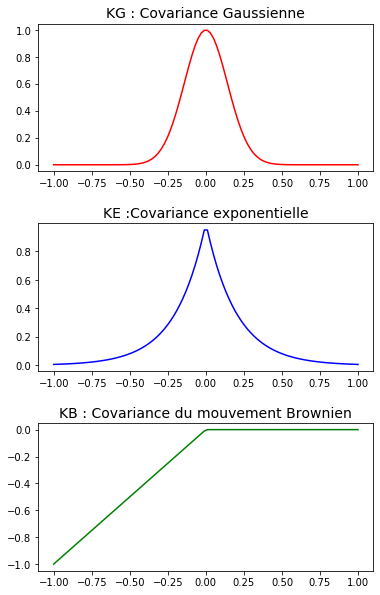

In [8]:
fig,ax=plt.subplots(3,1)
ax[0].plot(x,KGvals,'r')
ax[1].plot(x,KEvals,'b')
ax[2].plot(x,KBvals,'g')
ax[0].set_title("KG : Covariance Gaussienne",fontsize=14)
ax[1].set_title("KE :Covariance exponentielle",fontsize=14)
ax[2].set_title("KB : Covariance du mouvement Brownien" , fontsize=14)
plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=2,wspace=0.2,hspace=0.35)
plt.show()

### <font color='ushua'>2. Générer des réalisations de $\mathcal{N}(\mathbf{0}_{n'}, \mathbf{K}_{n'})$ sur l'intervalle $[0,1]$, sur une grille régulière $\mathcal{X}$ de taille $n'$ (e.g., avec un pas de $0.01$). 

<font size="4px"> $$[\mathbf{K}_{n'}]_{ij} = k_\cdot(\textbf{x}_i, \textbf{x}_j),  \ \ \ \textbf{x}_i, \textbf{x}_j \in \mathcal{X}.$$

In [9]:
def covariance_matrix(K,X,theta , sigma):
    return [[K(x,z,sigma,theta) for z in X ] for x in X]

---
### Avec la covariance gaussienne:
---

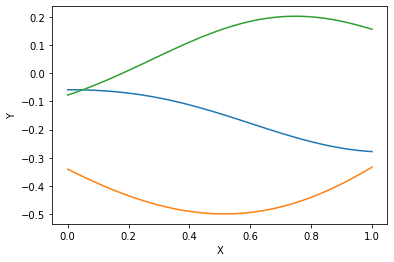

In [11]:
X=np.arange(0,1.01,0.01)  #[0,1] avec un pas de 0.01
mu=np.zeros(len(X))
K=covariance_matrix(KG,X,theta=0.2,sigma=1) # sigma contrôle l'amplitude et theta contrôle la fréquence

plt_vals=[]
for i in range(3):
  Y=np.random.multivariate_normal(mu,K)
  plt_vals.extend([X,Y])

plt.plot(*plt_vals)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

---
### Avec la covariance exponentielle:
---

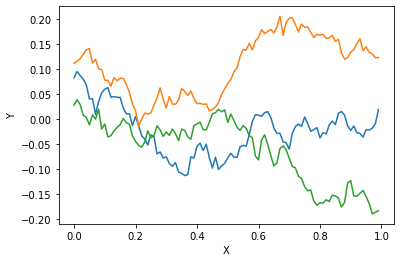

In [12]:
X=np.arange(0,1,0.01)
mu=np.zeros(len(X))
K=covariance_matrix(KE,X,theta=0.1,sigma=1) # sigma contrôle l'amplitude et theta contrôle la fréquence

plt_vals=[]
for i in range(3):
  Y=np.random.multivariate_normal(mu,K)
  plt_vals.extend([X,Y])

plt.plot(*plt_vals)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

---
<font color="red" size="4px">**Remarque**</font> : <font size="4px"> En jouant sur les valeurs de $\theta$ et de $\sigma$ , nous remarquons que $\sigma$ contrôle l'amplitude et $\theta$ contrôle la fréquence ; plus elle augmente plus la fréquence des oscillations diminue et nous remarquons également que les réalisations de la covariance gaussienne sont lisses , elles sont infiniment dérivables tandis que celles de la covariance exponentielle ne le sont pas ; elles sont juste continues.

---

###  <font color='ushua'> 3. On rappelle que:
<font size="4px"> $\mathbf{K}^{1/2} Z \sim \mathcal{N}(0, \mathbf{K})$ où $Z \sim \mathcal{N}(0, \mathbf{I})$ et $\mathbf{K}^{1/2}$ une matrice telle que $\mathbf{K}^{1/2}\mathbf{K}^{1/2} = \mathbf{K}$, <br>obtenue par example par diagonalisation. Commenter l'effet de $\theta$ ($\theta = 0.1, 0.5, 0.05$), <br>  $\sigma^2$ ($\sigma = 1, 10$) et du type de noyau sur les réalisations générées (e.g., 5-6 par configuration).

In [13]:
#matrice de covariance
def covariance_matrix(X,theta,sigma):
    return [[KE(x,z,theta,sigma) for x in X]for z in X]

In [14]:
def generation_gaussiens(theta,sigma):
    N=1000
    mu=np.zeros(N)
    start=0
    stop=1
    X=np.linspace(start,stop,N)
    theta=0.1
    sigma=1
    K=covariance_matrix(X,theta,sigma)
    #factorisation de K
    L=np.linalg.cholesky(K)
    Z=np.random.normal(size=N*3).reshape(3,N)
    VecteurGaussien=mu+np.dot(Z,L)
    return VecteurGaussien


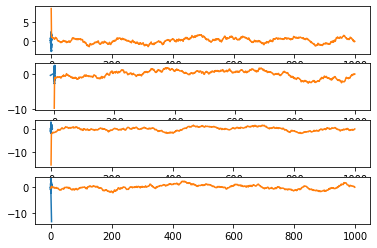

In [15]:
fig,ax=plt.subplots(4,1)
ax[0].plot(*generation_gaussiens(0.1,1))
ax[1].plot(*generation_gaussiens(0.1,10))
ax[2].plot(*generation_gaussiens(0.5,1))
ax[3].plot(*generation_gaussiens(0.5,10))

# <font color='purple'>  Partie 2 : Métamodélisation

<font size="4px">On se place dans un cadre *black-box* et on considère que les évaluations
sont *chères*, on cherche donc à limiter au maximum le nombre d'appels à
$f$.

Dans un premier temps, on considère la fonction Branin modifiée (un seul
minimum global) :

$$f_b(x) = \left(x_2 - \frac{5.1}{4\pi^2} x_1^2 + \frac{5}{\pi} x_1 -6 \right)^2 + 10 \left[ \left(1 - \frac{1}{8 \pi} \right)  \cos{x_1} + 1 \right] + 5 x_1, ~ x_1 \in [-5,10], x_2 \in [0,15].$$

Il s'agit d'implémenter les fonctions qui interviennent dans la régression par processus gaussien (ou krigeage). Il pourra être utile d'avoir des fonctions pour calculer directement la matrice de covariance d'une matrice d'expériences $\mathbf{X}_n$ (i.e., $\mathbf{K}_n)$, ainsi que le vecteur de covariance entre un design $x$ et $\mathbf{X}_n$ (i.e., $k(x, \mathbf{X}_n) := k_n(x)$).


 ---
 ### Avant d'entammer la deuxième partie nous tenons à présenter l'algorithme de EGO (Efficient Global Optimization) qui sera implémenté par étapes dans les parties qui suivent:

---
  - <font size="4px">Évaluer f sur un plan d’expériences initial<br><br>
  - Estimer les paramètres d’une covariance par maximum de vraisemblance.<br><br>
  - Calculer la prédiction par krigeage.<br><br>
  - Si La prédiction par krigeage n’est pas satisfaisante alors Transformer les données ou arrêter l’algorithme.<br><br>
  - Calculer fmin le minimum des résultats d’évaluations effectués.<br><br>
  - $ EI_{max} ← max_{x∈X} EI(x)$.<br><br>
  - Évaluer f au maximiseur de EI.<br><br>
  - Réestimer les paramètres de la covariance en tenant compte du résultat de la nouvelle évaluation.<br><br>
  - Mettre à jour la prédiction par krigeage.<br><br>
  - Mettre à jour $EI_{max}$ et $f_{min}$.<br><br>

---






### <font color='ushua'>1. Pour la prédiction et la création de figures, on prendra une grille régulière $\mathcal{X}$ (e.g., de taille $51 \times 51$). Afficher $f_b$ sur $\mathcal{X}$.


* ### Définition de la fonction de Branin

In [16]:
def Branin(x1,x2):
    C1=5.1/(2*np.pi)**2
    C2=5/np.pi
    C3=(1-1/(8*np.pi))
    return (x2-C1*x1**2+C2*x1-6)**2+10*(C3*np.cos(x1)+1)+5*x1

In [17]:
def Branin_cube(x1,x2): #pour projeter x1 et x2 sur [0,1]
    return Branin(15*x1-5,15*x2)

* ### Représentation graphique de la fonction

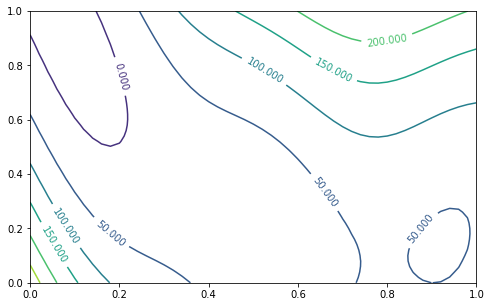

In [18]:
#représentation graphique 
fig= plt.figure(1,figsize=(8,5))
start,stop, n_values=0,1,51
x_vals=np.linspace(start,stop,n_values)
y_vals=np.linspace(start,stop,n_values)

X,Y=np.meshgrid(x_vals,y_vals) #maillage du domaine 
Z=Branin_cube(X,Y)
cp=plt.contour(X,Y,Z,5) #pour les courbes de niveaux
plt.clabel(cp,inline=True,fontsize=10) #clabel pour labeliser le contour
plt.show()


### <font color='ushua'>2. Plan d'expériences initial ($\mathbf{X}_9$): pour simplifier, on prendra pour  la grille regulière $3 \times 3$ dans $[0,1]^2$. Evaluer les réponses correspondantes ($\textbf{y}_9$).



### **Plan d'expérience intial X1:**

[[0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.5 0. ]
 [0.5 0.5]
 [0.5 1. ]
 [1.  0. ]
 [1.  0.5]
 [1.  1. ]]
[283.12909601  81.56869776  -7.49170048  22.80790849  36.62996441
 162.95202034  60.96088904  72.16653996 195.87219088]


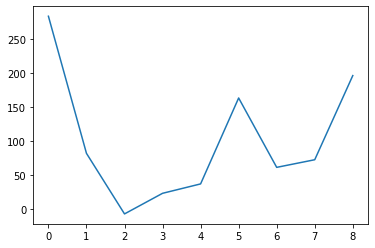

In [20]:
xgrid=np.linspace(0,1,3)
X1=np.array(np.meshgrid(xgrid,xgrid)).T.reshape(-1,2)
print(X1)
#les réponses correspondantes : y1
y1=Branin_cube(X1[:,0],X1[:,1])
print(y1)
plt.plot(y1);

---
- <font size="4px">C'est une représentation de l'évaluation de la fonction de Branin dans les 9 points de la grille définie ci-dessus.
---

### <font color='ushua'>3. On prendra ici une covariance gaussienne avec $\theta = 0.2$. Afficher la moyenne et la variance de prédiction par krigeage/processus gaussien en fonction de $x_1$ et $x_2$ sur $\mathcal{X}$. 
   
<font size="4px">   On rappelle que pour le krigeage simple, 
  $$m_n(\textbf{x}) = k_n(\textbf{x})^\top \mathbf{K}_n^{-1} \textbf{y}_n$$ 
   et 
   $$s_n^2(\textbf{x}) = k(\textbf{x}, \textbf{x}) - k_n(\textbf{x})^\top \mathbf{K}_n^{-1} k_n(\textbf{x}).$$ 

   De plus, l'estimateur $\hat{\sigma}^2_n$ obtenu par maximisation de la vraisemblance est $$\hat{\sigma}^2_n = \frac{1}{n} \textbf{y}_n^\top \mathbf{K}_n^{-1} \textbf{y}_n.$$ 

  Il peut être utile de sauver l'inverse de la matrice de covariance pour éviter de la recalculer.


In [21]:
def KG(x,z,theta,sigma):
    return (sigma**2)*np.exp(-np.linalg.norm(x-z)**2/theta**2)

def covariance_matrix(X1,X2,theta,sigma):
    row1=len(X1)
    row2=len(X2)
    K=np.zeros((row1,row2))
    i=0
    for xi in X1:
        j=0
        for xj in X2:
            K[i,j]=KG(xi.T,xj.T,theta,sigma)
            j+=1
        i+=1
    return K

ngrid=100
xgrid=np.linspace(0,1,ngrid)
Xgrid=np.array(np.meshgrid(xgrid,xgrid)).T.reshape(-1,2)
Ygrid=Branin_cube(Xgrid[:,0],Xgrid[:,1])  # l'évaluation de Xgrid

K1=covariance_matrix(X1,X1,theta=0.2,sigma=1) #sigma est estimé par maximisation de la fonction de vraisemblance
invK1=np.linalg.inv(K1+ 1e-6*np.eye(len(X1))) #ce terme à sa diagonale pour assurer un bon conditionnement de la matrice (assurer son inversibilité)
sigma2_hat1=(y1.T.dot(invK1).dot(y1))/len(y1)
kv1=covariance_matrix(Xgrid,X1,theta=0.2,sigma=1.0)
#Moyenne de prédiction par krigeage
mn1=kv1.dot(invK1).dot(y1)
print('La moyenne de prédiction par Krigeage est:')
print(mn1)
#variance de prédiction par krigeage
sn21=sigma2_hat1*(1-kv1.dot(invK1).dot(kv1.T))
print('************************************************')
print('La variance de prédiction par Krigeage est:')
print(sn21)

La moyenne de prédiction par Krigeage est:
[283.12881308 282.45236558 280.35647291 ... 193.97365421 195.41265477
 195.87199546]
************************************************
La variance de prédiction par Krigeage est:
[[1.80248436e-02 4.59364888e+01 1.82991206e+02 ... 1.80248616e+04
  1.80248616e+04 1.80248616e+04]
 [4.59364888e+01 9.17324598e+01 2.28431025e+02 ... 1.80248616e+04
  1.80248616e+04 1.80248616e+04]
 [1.82991206e+02 2.28431025e+02 3.64078580e+02 ... 1.80248616e+04
  1.80248616e+04 1.80248616e+04]
 ...
 [1.80248616e+04 1.80248616e+04 1.80248616e+04 ... 3.64078580e+02
  2.28431025e+02 1.82991206e+02]
 [1.80248616e+04 1.80248616e+04 1.80248616e+04 ... 2.28431025e+02
  9.17324598e+01 4.59364888e+01]
 [1.80248616e+04 1.80248616e+04 1.80248616e+04 ... 1.82991206e+02
  4.59364888e+01 1.80248436e-02]]


---
- <font size="4px">La moyenne est exactement $\mathbf{\lambda(x)}^\intercal F_n$ avec $\lambda(x)$ le vecteur des n coefficients de la prédiction par krigeage et $F_n$ est le vecteur aléatoire modélisant les résultats des évaluations aux points du plan d'expérience.<br><br>
- . Sous l’hypothèse gaussienne, la meilleure prédiction linéaire non biaisée est en effet la limite du predicteur bayésien lorsque la variance de l’a priori sur les coefficients de la combinaison linéaire définissant la moyenne de
F vers l’infini.
---

---
### <font color='ushua'>4. Comparer le résultat de la prédiction lorsque le plan d'expérience $\mathbf{X}_9$ est un hypercube latin (LHS). Dans ce cas, afficher la moyenne et variance de prédiction en fonction de $x_1$ et $x_2$ sur $\mathcal{X}$. 
---
 
 


In [22]:
#latin Hypercube Sampling
def latin_hypercube_2d_uniform(n):
    lower_limits=np.arange(0,n)/n
    upper_limits=np.arange(1,n+1)/n
    points=np.random.uniform(low=lower_limits,high=upper_limits,size=[2, n]).T
    np.random.shuffle(points[:,1])
    return points

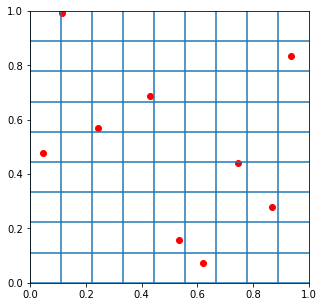

[[0.04730762 0.47654569]
 [0.11469806 0.99381499]
 [0.24358404 0.56926791]
 [0.4288311  0.68673174]
 [0.53549006 0.15580226]
 [0.62144687 0.07349133]
 [0.74669506 0.44163117]
 [0.86629334 0.27880979]
 [0.9367717  0.83615959]]


In [23]:
n=9
p=latin_hypercube_2d_uniform(n)
plt.figure(figsize=[5,5])
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(p[:,0],p[:,1],c='r')

for i in np.arange(0,1,1/n):
    plt.axvline(i)
    plt.axhline(i)

plt.show()
print(p)

---
<font size="4px">Dans le bloc précédent nous avons effectuer un échantillionnage par LHS cette méthode consiste à partitionner l’hypercube de départ en $n^d $sous-hypercubes identiques. Chaque dimension est donc divisée en n intervalles de même longueur. L’hypercube latin est alors construit de telle sorte que pour chacune des $d$ dimensions, chacun des $n$ intervalles soit associé à exactement un point. Autrement dit, chaque intervalle doit contenir une et une seule coordonnée : il ne doit pas y avoir de superposition des points lors de la projection sur un espace de dimension d − 1.
    
---



---
- <font size="4px">On recalcule la moyenne et la variance de prédiction par processus gaussien ( ou krigeage).
---

In [24]:
#latin Hypercube Sampling
X2=latin_hypercube_2d_uniform(9)
y2=Branin_cube(X2[:,0],X2[:,1])

K2=covariance_matrix(X2,X2,theta=0.2,sigma=1.0)

invK2=np.linalg.inv(K2+ 1e-6*np.eye(len(X2)))
sigma2_hat2=(y2.T.dot(invK2).dot(y2))/len(y2)
kv2=covariance_matrix(Xgrid,X2,theta=0.2,sigma=1.0)

In [25]:
#Moyenne de prédiction par krigeage
print('La moyenne de prédiction par krigeage:')
mn2=kv2.dot(invK2).dot(y2)
print(mn2)
#variance de prédiction par krigeage
print('La variance de prédiction par krigeage:')
sn22=sigma2_hat2*(1-kv2.dot(invK2).dot(kv2.T))
print(sn22)

La moyenne de prédiction par krigeage:
[2.19900217e-02 2.16814609e-02 2.06191905e-02 ... 2.67892255e+01
 2.63652257e+01 2.58177575e+01]
La variance de prédiction par krigeage:
[[6484.07588593 6484.07127518 6484.06645178 ... 6484.13280979
  6484.13280533 6484.13277412]
 [6484.07127518 6484.06612483 6484.06069509 ... 6484.13400225
  6484.13399689 6484.13395727]
 [6484.06645178 6484.06069509 6484.0545743  ... 6484.13551649
  6484.13551    6484.13545974]
 ...
 [6484.13280979 6484.13400225 6484.13551649 ... 6359.20278611
  6360.86615811 6363.14035879]
 [6484.13280533 6484.13399689 6484.13551    ... 6360.86615811
  6362.50519816 6364.74717755]
 [6484.13277412 6484.13395727 6484.13545974 ... 6363.14035879
  6364.74717755 6366.94603245]]


---
- <font size="4px">Pour comparer les résultats des deux plans d'expérience , on calcule la RMSE:
$RMSE=\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y_i})^2}$
---

In [26]:
ind=10
RMSE1=np.sqrt(np.mean((Ygrid - mn1)**2))
RMSE2=np.zeros(ind)
for i in range(ind):
    X2=latin_hypercube_2d_uniform(9)
    y2=Branin_cube(X2[:,0],X2[:,1])

    k2=covariance_matrix(X2,X2,theta=0.2,sigma=1.0)
    invK2=np.linalg.inv(K2+1e-6*np.eye(len(X2)))
    sigma2_hat2=(y2.T.dot(invK2).dot(y2))/len(y2)
    kv2=covariance_matrix(Xgrid,X2,theta=0.2,sigma=1.0)

    #Moyenne de prédiction par krigeage
    mn2=kv2.dot(invK2).dot(y2)
    #variance de prédiction par krigeage
    sn22=sigma2_hat2*(1-kv2.dot(invK2).dot(kv2.T))
  
    #RMSE
    RMSE2[i]=np.sqrt(np.mean((Ygrid - mn2)**2))
print('RMSE de 10 LHS', RMSE2)
print('Moyenne =', np.sum(RMSE2)/ind)
print('RMSE dans la grille régulière est:', RMSE1)

RMSE de 10 LHS [ 57.95887838  56.21000153 135.40523066 105.05716513  70.54795467
  59.25826799  95.91586045 203.96079112  75.42526008  72.41558321]
Moyenne = 93.2154993218805
RMSE dans la grille régulière est: 48.92835832212857


### <font color='ushua'>5. Utiliser la log-vraisemblance concentrée (en l'optimisant) pour estimer $\theta$, comparer au resultat précédent. en fonction de $x_1$ et $x_2$ sur $\mathcal{X}$. Afficher la moyenne et variance de prédiction avec les valeurs optimales.</font>

<font size="4px"> On rappelle que la log-vraisemblance concentrée s'écrit: 
$$\log \ell (\theta) = -\frac{n}{2} \log(2 \pi) - \frac{n}{2} \log \mathbf{y}_n^\top \mathbf{K}_n^{-1} \mathbf{y}_n - \frac{1}{2} \log |\mathbf{K}_n|.$$

In [27]:
from scipy.optimize import minimize
#vraisemblance
def vraisemblance(theta,X,y,eps):
    n=len(y)
    K=covariance_matrix(X,X,theta,sigma=1)+eps*np.eye(n)
    invK=np.linalg.inv(K)
    (sign,logdetK)=np.linalg.slogdet(K)
    nuhat=(y.T.dot(invK).dot(y))/n
    return n*np.log(2*np.pi)/2+n*np.log(nuhat)/2+logdetK/2

---
<font size="4px">**$\theta_{opt}$ sur le plan d'expérience X1**
    
---

In [28]:
bnds=((0.001,1.0),)
res=minimize(vraisemblance,0.2,args=(X1,y1,1e-6,),bounds=bnds,method='L-BFGS-B')
theta_opt1=res.x
print(theta_opt1)

[0.64229548]


---
<font size="4px">**$\theta_{opt}$ sur le plan d'expérience X2**

---

In [34]:
# calcul de l'optimum
bnds=((0.001,1.0),)
res=minimize(vraisemblance,0.2,args=(X2,y2,1e-6,),bounds=bnds,method='L-BFGS-B')
theta_opt2=res.x
print(theta_opt2)

[0.43815998]


---
- <font size="4px">Dans ce bloc nous avons estimé le paramètre $\theta$ par maximisation de la fonction de vraisemblance.Après l'avoir implémenté nous obtenant la valeur ci_dessous que nous allons mettre en évidence par une représentation graphique tout d'abord sur le plan d'expérience X1 puis sur X2.
---

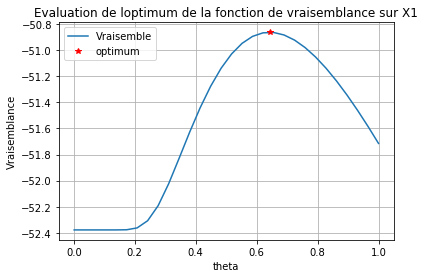

In [35]:
start=0.001
stop=1
nb_vals=30
theta_vals=np.linspace(start,stop,nb_vals)
vraisemblance_val1=[]
for i  in range(nb_vals):
    vraisemblance_val1.append(-vraisemblance(theta_vals[i],X1,y1,1e-6)) #evaluation des valeurs de theta

vraisemblance_opt1=-vraisemblance(theta_opt1,X1,y1,1e-6) #evaluation de l'optimum de la fonction de vraisemblance
plt.plot(theta_vals,vraisemblance_val1,label='Vraisemble');
plt.plot(theta_opt1,vraisemblance_opt1,'r*',label='optimum');
plt.xlabel('theta')
plt.ylabel('Vraisemblance')
plt.grid()
plt.title('Evaluation de loptimum de la fonction de vraisemblance sur X1' )
plt.legend();

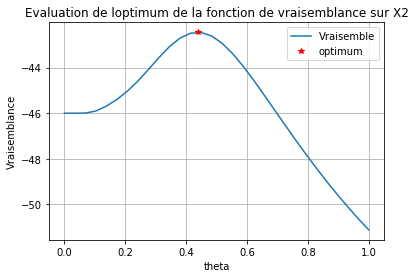

In [37]:
start=0.001
stop=1
nb_vals=30
theta_vals=np.linspace(start,stop,nb_vals)
vraisemblance_val2=[]
for i  in range(nb_vals):
    vraisemblance_val2.append(-vraisemblance(theta_vals[i],X2,y2,1e-6)) #evaluation des valeurs de theta

vraisemblance_opt2=-vraisemblance(theta_opt2,X2,y2,1e-6) #evaluation de l'optimum de la fonction de vraisemblance
plt.plot(theta_vals,vraisemblance_val2,label='Vraisemble')
plt.plot(theta_opt2,vraisemblance_opt2,'r*',label='optimum')
plt.xlabel('theta')
plt.ylabel('Vraisemblance')
plt.grid()
plt.title('Evaluation de loptimum de la fonction de vraisemblance sur X2' )
plt.legend();

---
- <font size="4px"> Calculons la moyenne et la variance avec la nouvelle valeur de $\theta$
    
---

In [86]:
#Using optimal parameters
K3=covariance_matrix(X2,X2,theta_opt2,sigma=1.0)
invK3=np.linalg.inv(K3+ 1e-6*np.eye(len(X2)))
sigma2_hat3=(y2.T.dot(invK3).dot(y2))/len(y2)
kv3=covariance_matrix(Xgrid,X2,theta_opt2,sigma=1.0)
#Moyenne de prédiction par krigeage
mn3=kv3.dot(invK3).dot(y2)
print('La moyenne de prédiction:')
print(mn3)
#variance de prédiction par krigeage
print('La variance de prédiction:')
sn23=sigma2_hat3*(1-kv3.dot(invK3).dot(kv3.T))
print(sn23)
RMS3=np.sqrt(np.mean(Ygrid-mn3)**2)
print('La RMS3 avec la nouvelle valeur de theta:',RMS3)

La moyenne de prédiction:
[ 54.14266363  54.25094598  54.28317076 ... 190.03911515 189.7638451
 189.38606919]
La variance de prédiction:
[[2856.31479104 2814.38126037 2775.60603055 ... 8404.74024078
  8416.17995676 8427.5493038 ]
 [2814.38126037 2770.3436257  2729.45067619 ... 8394.8446352
  8406.12762899 8417.33996722]
 [2775.60603055 2729.45067619 2686.42266419 ... 8384.74671031
  8395.87154606 8406.9256037 ]
 ...
 [8404.74024078 8394.8446352  8384.74671031 ...  648.82566451
   660.70871871  677.24539288]
 [8416.17995676 8406.12762899 8395.87154606 ...  660.70871871
   670.23492738  684.45374217]
 [8427.5493038  8417.33996722 8406.9256037  ...  677.24539288
   684.45374217  696.38934249]]
La RMS3 avec la nouvelle valeur de theta: 1.9980386785047235


---
- <font size="4px"> Nous remarquons que la RMSE a bien diminué en utilisant la valeur optimale de $\theta$ obtenue par maximisation de la fonction de vraisemblance.
---

# <font color='purple'> Partie 3 : EGO

<font size="4px"> On utilise maintenant les fonctions précédemment développées pour implémenter l'algorithme EGO.

### <font color="ushua">1. Ecrire la fonction d'amélioration espérée **EI** qui prend en entrée un nouveau design, et retourne l'amélioration espérée correspondante. Tracer la fonction EI en fonction de $x_1$ et $x_2$. 

 <font size="4px"> Rappel:
$$E[I(\textbf{x})|\mathbf{X}_n, \mathbf{y}_n ] = \left(t_n - m_n(\textbf{x})\right)\Phi\left(\frac{t_n - m_n(\textbf{x})}{s_n(\textbf{x})} \right)+s_n(\textbf{x})\phi\left(\frac{t_n - m_n(\textbf{x})}{s_n(\textbf{x})} \right),$$
où $\phi$ et $\Phi$ sont la densité et la fonction de répartition de la loi normale standard, $t_{n}=\min _{1 \leq i \leq n} y_{i}.$



---
- <font size="4px"> Afin de cibler le choix des points dans une optique d’optimisation de l’efficience, nous utiliserons le critère dit d’amélioration espérée ou « expected improvement » qui est donc un compromis entre les endroits où la moyenne est faible et ceux où la variance est élevé , elle est définie comme suit:     <font color='orange' >$max(min(f(x_i)-Y(x),0)$
---

In [38]:
def EI(x, theta , sigma2, invK, X, y):
    Xs=np.vstack((X,x))
    kvec=covariance_matrix(Xs,X,theta=theta,sigma=1.0)
    mn=kvec.dot(invK).dot(y)
    sn2=sigma2*(1-kvec.dot(invK).dot(kvec.T))
    f_min=min(y)
    arg=(f_min-mn)/np.sqrt(sn2)
    res=(f_min-mn)*norm.cdf(arg)+np.sqrt(sn2)*norm.pdf(arg)
    res=np.linalg.norm(res,np.inf)
    return -res #this EI needs to be maximized

---
###  <font color="ushua">2. Ecrire la fonction **EGO_one_step** qui maximise l'EI sur le domaine de conception. 

---

In [39]:
def EGO_one_step(X,y):
    n=len(y)
    #i) optimize hyperparameters
    bndsVS=((0.001, 1.0),)
    resVS=minimize(vraisemblance,0.2,args=(X,y,1e-6,), bounds=bndsVS,method='L-BFGS-B')
    theta=resVS.x 
    #ii) model fit
    K=covariance_matrix(X,X,theta=theta,sigma=1.0) #sigma estimated by plugin
    invK=np.linalg.inv(K+1e-6*np.eye(n))
    sigma2_hat=(y.T.dot(invK).dot(y))/n
    #ii) EI optimization
    bndsEI=((0.001,1.0),(0.001,1.0),)
    resEI=minimize(EI,x0=[0.1,0.1],args=(theta,sigma2_hat,invK,X,y,),bounds=bndsEI,method='L-BFGS-B') #BFGS
    
    return resEI

---
###  <font color="ushua">3. Regarder la performance sur 21 pas (budget total de 30 évaluations). Comparer à d'autres méthodes d'optimisation (e.g., descente de gradient, recherche aléatoire).
    
---

In [40]:
X2=latin_hypercube_2d_uniform(9)
y2=Branin_cube(X2[:,0],X2[:,1])

X0=X2
y0=y2
nsteps=30

for i in range(nsteps):
    #Find best new point
    res=EGO_one_step(X0,y0)
    Xnew=res.x
    
    #Evaluate it
    ynew=Branin_cube(Xnew[0],Xnew[1])

    #Add new point to previous points
    X0=np.vstack((X0,Xnew))
    y0=np.hstack((y0,ynew))

    print('Xnew:', Xnew, '-> ynew :', ynew)

Xnew: [0.001      0.63066234] -> ynew : 46.70731327229541
Xnew: [0.33103775 0.45989561] -> ynew : 20.13570750015662
Xnew: [0.001      0.94568167] -> ynew : -3.5844942819161254
Xnew: [0.08885281 0.81641522] -> ynew : -14.879384318482233
Xnew: [0.09273043 0.80516516] -> ynew : -14.797015762777301
Xnew: [0.07702686 0.82007033] -> ynew : -13.564978049974071
Xnew: [0.08468651 1.        ] -> ynew : -15.032219730091542
Xnew: [0.10191608 0.84361792] -> ynew : -16.258976251246345
Xnew: [0.77081241 0.001     ] -> ynew : 53.26041669470541
Xnew: [0.09506195 0.9068132 ] -> ynew : -16.51886818019222
Xnew: [0.096454   0.89668701] -> ynew : -16.53914353999217
Xnew: [0.09711551 0.89624883] -> ynew : -16.520862228437583
Xnew: [0.09736534 0.89608753] -> ynew : -16.51353620347912
Xnew: [0.09747974 0.89616437] -> ynew : -16.509231302280256
Xnew: [0.09766143 0.89521938] -> ynew : -16.50848222890544
Xnew: [0.09752228 0.89489465] -> ynew : -16.514903374643094
Xnew: [0.09745    0.89727257] -> ynew : -16.503520


---
* <font size="5px" color="green">Nous obtenons après environ 25 itérations , une valeur très acceptable d'un minimum un peu près égal à $-16.6$
---